# Магазин продуктов питания

## Содержание:

1. Изучение общей информации, предварительный просмотр данных

- 1.1 Импортируем все нужные библиотеки
- 1.2 Загрузка файла и предварительный просмотр данны

2. Подготовка данных

- 2.1. Замена названий столбцов
- 2.2. Преобразование данных в нужные типы, обработка пропусков
- 2.3. Добавление столбца даты и времени, а также отдельного столбца дат

3. Изучение и проверка данных

- 3.1. Количество событий в логе
- 3.2. Количество пользователей в логе
- 3.3. Среднее число событий приходится на пользователя
- 3.4. Вопросы по данным
- 3.5. Количество событий и пользователей которое вы потеряли, отбросив старые данные
- 3.6. Проверка наличия пользователей из всех трёх экспериментальных групп

4. Изучиение воронки событий

- 4.1. Какие события есть в логах, как часто они встречаются
- 4.2. Сколько пользователей совершали каждое из этих событий
- 4.3. В каком порядке происходят события
- 4.4. Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
- 4.5. Доля пользователей доходит от первого события до оплаты

5. Изучение результатов эксперимента

- 5.1. Сколько пользователей в каждой экспериментальной группе?
- 5.2. Проверка, находят ли статистические критерии разницу между выборками 246 и 247.
- 5.3. Самое популярное событие
- 5.4. Сравнение результатов с каждой из контрольных групп в отдельности по каждому событию
- 5.5. Уровень значимости вы выбрали при проверке статистических гипотез выше

6. Общий вывод

<b>Цель исследования</b> - Изучить воронку продаж, исследование результатов A/A/B-эксперимента

<b>Исходные данные</b> - данные стартапа, который продаёт продукты питания.

**Описание данных**

Файл /datasets/logs_exp.csv
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## 1. Изучение общей информации, предварительный просмотр данных 

#### 1.1. Импортируем все нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy as sp
import plotly as pt
from math import sqrt
from math import fabs

In [2]:
try:
    df = pd.read_csv('D:///datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net//datasets/logs_exp.csv', sep='\t')

In [3]:
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:** Имеем 1 датафрейм с 4 колонками и 244126 строками, бросаются в глаза не корректные названия столбцов, в последствии заменим их

## 2. Подготовка данных

#### 2.1. Замена названий столбцов 

Приведем все названия столбцов к нижнему змеиному регистру

In [5]:
df = df.rename(columns={"EventName": "event_name", "DeviceIDHash": "user_id", "EventTimestamp": "event_datetime", "ExpId": "group"})
df.head()

,event_name,user_id,event_datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### 2.2. Преобразование данных в нужные типы, обработка пропусков и дубликатов

Т.к. неккоректно введенных форматов ячеек у нас нет, то следует проверить данные на дубликаты

In [6]:
print("Дубликатов обнаружено:", df.duplicated().sum())

Дубликатов обнаружено: 413


In [7]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_name      243713 non-null  object
 1   user_id         243713 non-null  int64 
 2   event_datetime  243713 non-null  int64 
 3   group           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


**Вывод:** После удаления 413 дубликатов у нас остается 243713 строк(Также считаю удаление дубликатов рациональным, т.к. они не составляют и половины % от всех данных)

#### 2.3. Добавление столбца даты и времени, а также отдельного столбца дат

Добавим столбец даты и времени, а также отдельный столбец дат

In [8]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'], unit='s')
df['date'] = df['event_datetime'].dt.strftime('%Y-%m-%d')

In [9]:
df.head(10)

,event_name,user_id,event_datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


**Общий вывод:**
- После удаления 413 дубликатов у нас остается 243713 строк(Также считаю удаление дубликатов рациональным, т.к. они не составляют и половины % от всех данных)
- Добавлены ячейки с датами

## 3. Изучение и проверка данных

#### 3.1. Количество событий в логе

In [10]:
print('Событий в логе:', df['user_id'].count())

Событий в логе: 243713


#### 3.2. Количество пользователей в логе

In [11]:
print('Пользователей в логе:', df['user_id'].nunique())

Пользователей в логе: 7551


#### 3.3. Среднее число событий приходится на пользователя

In [12]:
print('В среднем событий на пользователя приходится:',
      int(df.groupby('user_id')['event_name'].agg('count').median()))

В среднем событий на пользователя приходится: 20


#### 3.4. Вопросы по данным

**Ответим на вопросы:**
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. 
- Постройте гистограмму по дате и времени. 
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период? 
- Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. 
- Данными за какой период времени вы располагаете на самом деле?

In [13]:
print('Логи за период с {} по {}.'.format(df['event_datetime'].min(), df['event_datetime'].max()))

Логи за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17.


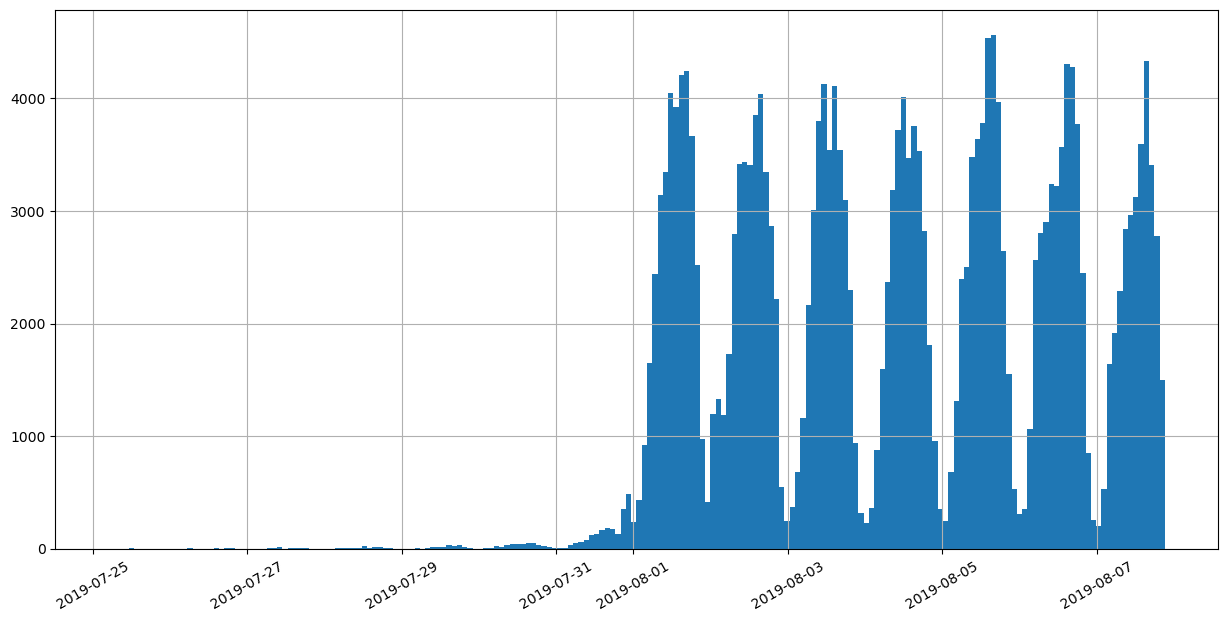

In [14]:
df['event_datetime'].hist(figsize=(15, 7), bins=200)
plt.xticks(rotation=30)
plt.show()

Можно ли быть уверенным, что у вас одинаково полные данные за весь период?
- Думаю, что глядя на гистограмму можно сделать вывод, что полные данные у нас хранятся в период с 2019-08-01 по 2019-08-07

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые.
- Исходя из гистограммы следует отбросить все данные до 2019-08-01, а временной промежуток с 1 по 7 августа можно считать полным.

In [15]:
data = df.query('date >= "2019-08-01"')
print("Начальная дата наблюдений", df['date'].min())

Начальная дата наблюдений 2019-07-25


**Выводы:**
- Событий в логе: 243713
- Пользователей в логе: 7551
- Теперь мы располагаем новым временным промежутком: 1-7 августа 2019 года.
- В среднем событий на пользователя приходится: 20


#### 3.5. Количество событий и пользователей которое вы потеряли, отбросив старые данные

In [16]:
print('Потеряли событий:', len(df) - len(data))
print('В процентах:', round((len(df) - len(data)) / len(df) * 100, 2))
print("Потеряли пользователей:", df['user_id'].nunique() - data['user_id'].nunique())
print("Потеряли пользователей в процентах:", round((df['user_id'].nunique() - data['user_id'].nunique()) / df['user_id'].nunique() * 100, 2))

Потеряли событий: 2826
В процентах: 1.16
Потеряли пользователей: 17
Потеряли пользователей в процентах: 0.23


**Вывод:** 
- После корректировки дат потеряли 2826 событий, что составляет 1.16 процента
- После корректировки дат потеряли 17 пользователей, что составляет 0.23 процента

#### 3.6. Проверка наличия пользователей из всех трёх экспериментальных групп

In [17]:
data.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


**Вывод:** 
- Пользователи из всех трех  экспериментальных групп остались

**Общий вывод:**
- Событий в логе: 243713
- Пользователей в логе: 7551
- Теперь мы располагаем новым временным промежутком: 1-7 августа 2019 года.
- В среднем событий на пользователя приходится: 20
- После корректировки дат потеряли 2826 событий, что составляет 1.16 процента
- После корректировки дат потеряли 17 пользователей, что составляет 0.23 процента
- Пользователи из всех трех экспериментальных групп остались

## 4. Изучиение воронки событий

#### 4.1. Какие события есть в логах, как часто они встречаются

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [18]:
data.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

**Вывод:**
- Встречаются 5 событий, самое распространенное это **MainScreenAppear**, а самое редкое **Tutorial**

#### 4.2. Сколько пользователей совершали каждое из этих событий

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [19]:
events = df.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
events.columns = ['event_name', 'users']
events['percent'] = events['users'] / df['user_id'].nunique()
events

,event_name,users,percent
0,MainScreenAppear,7439,0.985168
1,OffersScreenAppear,4613,0.610912
2,CartScreenAppear,3749,0.496491
3,PaymentScreenSuccessful,3547,0.469739
4,Tutorial,847,0.112171


**Вывод:**
- 98.5% пользователей доходят до главного экрана, затем предложение появляется у 61%. До оплаты доходят 49.6%, а успешно оплачивают 46.9%. Где-то теряется 2.7% пользователей.

#### 4.3. В каком порядке происходят события

Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

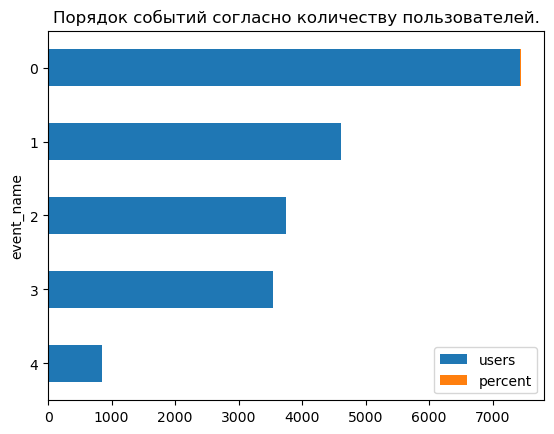

In [20]:
events.sort_values(by='users').plot.barh(stacked=True, ylabel='event_name')
plt.title('Порядок событий согласно количеству пользователей.')
plt.show()

**Вывод:**
- Итак, можно сказать, что туториал не входит в цепочку событий, он может быть доступен на всех этапах. Следовательно Составить цепочку событий можно так: **MainScreenAppear** - **OffersScreenAppear** - **CartScreenAppear** - **PaymentScreenSuccessful**

#### 4.4. Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B. На каком шаге теряете больше всего пользователей?

In [21]:
conversion = events[['event_name', 'percent']].query('event_name != "Tutorial"')
for index in range(0, len(conversion)):
    if index == 0:
        conversion.loc[index, 'conversion_per_step'] = 100
    else:
        conversion.loc[index, 'conversion_per_step'] = conversion.loc[index, 'percent'] * 100 / conversion.loc[index - 1, 'percent']
conversion

,event_name,percent,conversion_per_step
0,MainScreenAppear,0.985168,100.000000
1,OffersScreenAppear,0.610912,62.011023
2,CartScreenAppear,0.496491,81.270323
3,PaymentScreenSuccessful,0.469739,94.611897


**Вывод:**
- Самые большие потери происходят при переходе от Основного экрана до экрана с предложением
- Также между заполнением данных карты и оплатой теряется практически 200 человек

#### 4.5. Доля пользователей доходит от первого события до оплаты

In [22]:
for index in range(0, len(conversion)):
    if index == 0:
        conversion.loc[index, 'conversion'] = 100
    else:
        conversion.loc[index, 'conversion'] = conversion.loc[index, 'percent'] * 100 / conversion.loc[0, 'percent']
conversion

,event_name,percent,conversion_per_step,conversion
0,MainScreenAppear,0.985168,100.000000,100.000000
1,OffersScreenAppear,0.610912,62.011023,62.011023
2,CartScreenAppear,0.496491,81.270323,50.396559
3,PaymentScreenSuccessful,0.469739,94.611897,47.681140


**Вывод:**
- От страницы главного экрана до оплаты доходит только 47.68% от всех пользователей

**Общий вывод:**
- Встречаются 5 событий, самое распространенное это MainScreenAppear, а самое редкое Tutorial
- 98.5% пользователей доходят до главного экрана, затем предложение появляется у 61%. До оплаты доходят 49.6%, а успешно оплачивают 46.9%. Где-то теряется 2.7% пользователей.
- Можно сказать, что туториал не входит в цепочку событий, он может быть доступен на всех этапах. Следовательно Составить цепочку событий можно так: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful
- Самые большие потери происходят при переходе от Основного экрана до экрана с предложением
- Также между заполнением данных карты и оплатой теряется практически 200 человек
- От страницы главного экрана до оплаты доходит только 47.68% от всех пользователей

## 5. Изучение результатов эксперимент

#### 5.1. Сколько пользователей в каждой экспериментальной группе?

In [23]:
data.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


**Вывод:**
- В группе 246 - 2484 пользователей
- В группе 247 - 2513 пользователей
- В группе 248 - 2537 пользователей

#### 5.2. Проверка, находят ли статистические критерии разницу между выборками 246 и 247.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [24]:
MainScreenAppear = df.query('event_name == "MainScreenAppear" & (group == 246 | group == 247)').groupby('group').agg({'user_id':'nunique'})
MainScreenAppear.columns = ['count_users']
MainScreenAppear_246 = df.query('group == 246')['user_id'].nunique()
MainScreenAppear_247 = df.query('group == 247')['user_id'].nunique()
MainScreenAppear.loc[246, 'share_users'] = MainScreenAppear.loc[246, 'count_users'] / MainScreenAppear_246
MainScreenAppear.loc[247, 'share_users'] = MainScreenAppear.loc[247, 'count_users'] / MainScreenAppear_247
MainScreenAppear

,count_users,share_users
group,,
246,2456,0.986742
247,2482,0.984921


In [25]:
MainScreenAppear['share_users'].loc[246]

0.9867416633186018

In [26]:
print('Разница между группами 246 и 247 составляет:', round(MainScreenAppear['share_users'].loc[246]-MainScreenAppear['share_users'].loc[247], 3))

Разница между группами 246 и 247 составляет: 0.002


In [27]:
OffersScreenAppear = df.query('event_name == "OffersScreenAppear" & (group == 246 | group == 247)').groupby('group').agg({'user_id':'nunique'})
OffersScreenAppear.columns = ['count_users']
OffersScreenAppear_246 = df.query('group == 246')['user_id'].nunique()
OffersScreenAppear_247 = df.query('group == 247')['user_id'].nunique()
OffersScreenAppear.loc[246, 'share_users'] = OffersScreenAppear.loc[246, 'count_users'] / OffersScreenAppear_246
OffersScreenAppear.loc[247, 'share_users'] = OffersScreenAppear.loc[247, 'count_users'] / OffersScreenAppear_247
OffersScreenAppear

,count_users,share_users
group,,
246,1545,0.620731
247,1530,0.607143


In [28]:
print('Разница между группами 246 и 247 составляет:', round(OffersScreenAppear['share_users'].loc[246]-OffersScreenAppear['share_users'].loc[247], 3))

Разница между группами 246 и 247 составляет: 0.014


In [29]:
CartScreenAppear = df.query('event_name == "CartScreenAppear" & (group == 246 | group == 247)').groupby('group').agg({'user_id':'nunique'})
CartScreenAppear.columns = ['count_users']
CartScreenAppear_246 = df.query('group == 246')['user_id'].nunique()
CartScreenAppear_247 = df.query('group == 247')['user_id'].nunique()
CartScreenAppear.loc[246, 'share_users'] = CartScreenAppear.loc[246, 'count_users'] / CartScreenAppear_246
CartScreenAppear.loc[247, 'share_users'] = CartScreenAppear.loc[247, 'count_users'] / CartScreenAppear_247
CartScreenAppear

,count_users,share_users
group,,
246,1270,0.510245
247,1240,0.492063


In [30]:
print('Разница между группами 246 и 247 составляет:', round(CartScreenAppear['share_users'].loc[246]-CartScreenAppear['share_users'].loc[247], 3))

Разница между группами 246 и 247 составляет: 0.018


In [31]:
PaymentScreenSuccessful = df.query('event_name == "PaymentScreenSuccessful" & (group == 246 | group == 247)').groupby('group').agg({'user_id':'nunique'})
PaymentScreenSuccessful.columns = ['count_users']
PaymentScreenSuccessful_246 = df.query('group == 246')['user_id'].nunique()
PaymentScreenSuccessful_247 = df.query('group == 247')['user_id'].nunique()
PaymentScreenSuccessful.loc[246, 'share_users'] = PaymentScreenSuccessful.loc[246, 'count_users'] / PaymentScreenSuccessful_246
PaymentScreenSuccessful.loc[247, 'share_users'] = PaymentScreenSuccessful.loc[247, 'count_users'] / PaymentScreenSuccessful_247
PaymentScreenSuccessful.style

,count_users,share_users
group,,
246,1202,0.482925
247,1160,0.460317


In [32]:
print('Разница между группами 246 и 247 составляет:', round(PaymentScreenSuccessful['share_users'].loc[246]-PaymentScreenSuccessful['share_users'].loc[247], 3))

Разница между группами 246 и 247 составляет: 0.023


**Вывод:**
- Максимальная разница по каждому событию составляет 0.02%, что говорит о практически нулевой разницы в выборках

#### 5.3. Самое популярное событие

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

**Установим нулевую и альтернативную гипотезы:**
- Нулевая: статистических различий между данными нет
- Альтернативная: статистические различия между данными есть

In [33]:
# напишем функцию для автоматизации теста
def test(group1, group2, event, alpha):

    def successes_trials(group1, group2, event):
    
        successes = np.array([data.query(f'group == {group1} & event_name == "{event}"')['user_id'].nunique(),\
                          data.query(f'group == {group2} & event_name == "{event}"')['user_id'].nunique()])

        trials = np.array([data.query(f'group == {group1}')['user_id'].nunique(),\
                           data.query(f'group == {group2}')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = sp.stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты теста для групп {group1} и {group2} и события {event}')
 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: статистические различия между данными есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет')

In [34]:
test(246, 247, 'MainScreenAppear', 0.05)
print('')
test(246, 247, 'OffersScreenAppear', 0.05)
print('')
test(246, 247, 'CartScreenAppear', 0.05)
print('')
test(246, 247, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 247 и события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 247 и события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 247 и события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 247 и события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет


**Вывод:**
- Исходя из проведенного выше теста можно сказать, что статистических различий между данными нет

#### 5.4. Сравнение результатов с каждой из контрольных групп в отдельности по каждому событию

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

**Установим нулевую и альтернативную гипотезы:**
- Нулевая: статистических различий между данными нет
- Альтернативная: статистические различия между данными есть

Для начала сравним группы 246 и 248

In [35]:
test(246, 248, 'MainScreenAppear', 0.05)
print('')
test(246, 248, 'OffersScreenAppear', 0.05)
print('')
test(246, 248, 'CartScreenAppear', 0.05)
print('')
test(246, 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 248 и события MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 248 и события OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 248 и события CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 246 и 248 и события PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет


**Вывод:**
- Между группами 246 и 248 по всем событиям статистических различий между данными нет

Теперь сравним группы 247 и 248

In [36]:
test(247, 248, 'MainScreenAppear', 0.05)
print('')
test(247, 248, 'OffersScreenAppear', 0.05)
print('')
test(247, 248, 'CartScreenAppear', 0.05)
print('')
test(247, 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 247 и 248 и события MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 247 и 248 и события OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 247 и 248 и события CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп 247 и 248 и события PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет


**Вывод:**
- Между группами 247 и 248 по всем событиям статистических различий между данными нет

Теперь сравним группы 246, 247 с экспериментальной 248

In [37]:
def new_test(group1, group2, event, alpha):

    def successes_trials_3_groups(group1, group2, event):
    #изменили вот тут
        successes = np.array([data.query(f'group.isin({group1}) & event_name == "{event}"')['user_id'].nunique(),\
                              data.query(f'group == {group2} & event_name == "{event}"')['user_id'].nunique()])
    #и вот тут
        trials = np.array([data.query(f'group.isin({group1})')['user_id'].nunique(),\
                           data.query(f'group == {group2}')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials_3_groups(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = sp.stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты теста для групп {group1} и {group2} и события {event}')
 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: статистические различия между данными есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет')

**Установим нулевую и альтернативную гипотезы:**
- Нулевая: статистических различий между данными нет
- Альтернативная: статистические различия между данными есть

In [38]:
new_test([246, 247], 248, 'MainScreenAppear', 0.05)
print()
new_test([246, 247], 248, 'OffersScreenAppear', 0.05)
print()
new_test([246, 247], 248, 'CartScreenAppear', 0.05)
print()
new_test([246, 247], 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп [246, 247] и 248 и события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп [246, 247] и 248 и события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп [246, 247] и 248 и события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет

Результаты теста для групп [246, 247] и 248 и события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, статистических различий между данными нет


**Вывод:**
- Статистических различий между группами 246, 247 с экспериментальной 248 нет по всем событиям, соответственно нельзя отвергнуть нулевую гипотезу. Изменение шрифтов в приложении не повлияло на продажи

#### 5.5. Уровень значимости вы выбрали при проверке статистических гипотез выше.

Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?

**Вывод:**
- Был установлен статистический уровень значимости в 5%. Всего было произведено 20 проверок статистических гипотез. В нашем случае ставить уровень значимости 0.1 не имеет смысла, ведь при уровне в 5% мы уже выяснили, что в каждом тесте статистических различий между данными нет.

**Общий вывод:**
- В группе **246** - 2484 пользователей, в группе **247** - 2513 пользователей, в группе **248** - 2537 пользователей
- Максимальная разница по каждому событию у групп 246 и 247 составляет 0.02%, что говорит о практически нулевой разницы в выборках
- Исходя из проведенного теста с группами **246** и **247** можно сказать, что статистических различий между данными нет
- Между группами **246** и **248** по всем событиям статистических различий между данными нет
- Между группами **247** и **248** по всем событиям статистических различий между данными нет
- Статистических различий между группами **246, 247** с экспериментальной **248** нет по всем событиям, соответственно нельзя отвергнуть нулевую гипотезу. Изменение шрифтов в приложении не повлияло на продажи
- Был установлен статистический уровень значимости в 5%. Всего было произведено 20 проверок статистических гипотез. В нашем случае ставить уровень значимости 0.1 не имеет смысла, ведь при уровне в 5% мы уже выяснили, что в каждом тесте статистических различий между данными нет

## 6. Общий вывод

**В самом начале проекта мы:**

- ознакомились с первичным форматом данных

- выполнили предварительную оценку данных

**По ходу первоначального анализа было выявлено:**

- 1 датафрейм без пропусков c 4 колонками и 244126 строками

**Также было обнаружено:**

- неккректная запись столбцов, привели к нижнему регистру


**В ходе второй части работы была произведена:**

- изменили неккоректные названия солбцов

- добавлены 2 колонки с датами

- выявлены 413 дубликатов и в последствии удалены


**Изучение и проверка данных дали возможность сделать выводы:**

- Событий в логе: 243713
- Пользователей в логе: 7551
- Теперь мы располагаем новым временным промежутком: 1-7 августа 2019 года.
- В среднем событий на пользователя приходится: 20
- После корректировки дат потеряли 2826 событий, что составляет 1.16 процента
- После корректировки дат потеряли 17 пользователей, что составляет 0.23 процента
- Пользователи из всех трех экспериментальных групп остались
 
**Четвертая часть с А/В тестом дала понять некоторые вещи:**

- Встречаются 5 событий, самое распространенное это MainScreenAppear, а самое редкое Tutorial
- 98.5% пользователей доходят до главного экрана, затем предложение появляется у 61%. До оплаты доходят 49.6%, а успешно оплачивают 46.9%. Где-то теряется 2.7% пользователей.
- Можно сказать, что туториал не входит в цепочку событий, он может быть доступен на всех этапах. Следовательно Составить цепочку событий можно так: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful
- Самые большие потери происходят при переходе от Основного экрана до экрана с предложением
- Также между заполнением данных карты и оплатой теряется практически 200 человек
- От страницы главного экрана до оплаты доходит только 47.68% от всех пользователей


**В пятой части сделаны выводы:**

- В группе **246** - 2484 пользователей, в группе **247** - 2513 пользователей, в группе **248** - 2537 пользователей
- Максимальная разница по каждому событию у групп 246 и 247 составляет 0.02%, что говорит о практически нулевой разницы в выборках
- Исходя из проведенного теста с группами **246** и **247** можно сказать, что статистических различий между данными нет
- Между группами **246** и **248** по всем событиям статистических различий между данными нет
- Между группами **247** и **248** по всем событиям статистических различий между данными нет
- Статистических различий между группами **246, 247** с экспериментальной **248** нет по всем событиям, соответственно нельзя отвергнуть нулевую гипотезу. Изменение шрифтов в приложении не повлияло на продажи
- Был установлен статистический уровень значимости в 5%. Всего было произведено 20 проверок статистических гипотез. В нашем случае ставить уровень значимости 0.1 не имеет смысла, ведь при уровне в 5% мы уже выяснили, что в каждом тесте статистических различий между данными нет


## Доп. задания

- 1. Сначала подготовить данные, по которым будет идти проверка (сводная таблица с количеством пользователей совершивших каждое из событий)
- 2. Написать функцию, которая принимает в качестве аргументов 4 числа для z-теста пропорций (в теле функции не должно быть ни цикла, ни работы с датафреймом, только мат. вычисления для стат. теста)
- 3. Для каждой пары групп вызывать функцию в цикле, итерируясь по датафрейму с данными для проверки гипотез (не 1 цикл, а для каждой пары групп, т.е. всего 4 цикла)
- 4. Ты выбираешь уровень значимости 0.05, это означает, что допустимая вероятность ложположительного результата для одного теста - 5%. У нас 16 тестов, какой в таком случае становится допустимая вероятность ложноположительного результата хотя бы в одном из тестов?И какой в таком случае следует использовать уровень значимости?

#### 1. Сначала подготовим данные, по которым будет идти проверка (сводная таблица с количеством пользователей совершивших каждое из событий)

Так понимаю Нужны люди, которые прошли все события за исключением туториала(его просто не целесообразно рассматривать). Соотвестветнно нам нужны люди, которые прошли от главного экрана до успешной оплаты. Составим таблицу

In [39]:
data['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [40]:
data.head()

,event_name,user_id,event_datetime,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [41]:
user_all = data[data['event_name'] != 'Tutorial']
user_all_events = user_all.groupby(['user_id', 'group']).agg({'event_name': 'nunique'}).reset_index()
user_all_events = user_all_events[user_all_events['event_name'] == 4]
user_all_events.columns = user_all_events.columns.map(''.join)
user_all_events


,user_id,group,event_name
1,6909561520679493,247,4
2,6922444491712477,246,4
4,7702139951469979,247,4
7,9841258664663090,248,4
9,15708180189885246,246,4
...,...,...,...
7518,9212420551954885212,248,4
7520,9212961170535635779,246,4
7521,9214668690707156694,248,4
7524,9216369613838971606,246,4


**Вывод:**
- Получили 3429 пользователей

#### 2. Напишем функцию, которая принимает в качестве аргументов 4 числа для z-теста пропорций (в теле функции не должно быть ни цикла, ни работы с датафреймом, только мат. вычисления для стат. теста)

In [42]:
def z_test(group1, group2, size):
    p1 = group1 / size
    p2 = group1 / size
    P = (p1*size + p2*size) / (size + size)
    se = sqrt(P*(1-P) * (1/size + 1/size))
    z = (p1 - p2) / se

    p_val = (1 - sp.stats.norm.cdf(abs(z))) * 2
    alpha = .05
    if p_val > alpha:
        print('Оснований отвергать нулевую гипотезу нет, p_val > alpha')
    else:
        print('Основания отвергать нулевую гипотезу есть, p_val < alpha')

#### 3. Для каждой пары групп вызывать функцию в цикле, итерируясь по датафрейму с данными для проверки гипотез (не 1 цикл, а для каждой пары групп, т.е. всего 4 цикла)

Для начала выдвинем нулевую и альтенрнативную гипотезы:
- Между группами нет стат.разницы

Альтернативная:
- Между группами есть стат.разницa

Сравниваем 246 и 247 группы

In [43]:
 z_test(user_all_events['user_id'][user_all_events['group']==246].count(),
        user_all_events['user_id'][user_all_events['group']==247].count(), 
        user_all_events['user_id'].count())

Оснований отвергать нулевую гипотезу нет, p_val > alpha


Сравниваем 246 и 248 группы

In [44]:
 z_test(user_all_events['user_id'][user_all_events['group']==246].count(),
        user_all_events['user_id'][user_all_events['group']==248].count(), 
        user_all_events['user_id'].count())

Оснований отвергать нулевую гипотезу нет, p_val > alpha


Сравниваем 247 и 248 группы

In [45]:
 z_test(user_all_events['user_id'][user_all_events['group']==248].count(),
        user_all_events['user_id'][user_all_events['group']==247].count(), 
        user_all_events['user_id'].count())

Оснований отвергать нулевую гипотезу нет, p_val > alpha


Сравниваем 246, 247 и 248 группы

In [46]:
 z_test(user_all_events['user_id'][user_all_events['group']==246 | 247].count(),
        user_all_events['user_id'][user_all_events['group']==248].count(), 
        user_all_events['user_id'].count())

Оснований отвергать нулевую гипотезу нет, p_val > alpha


#### 4. Ты выбираешь уровень значимости 0.05, это означает, что допустимая вероятность ложположительного результата для одного теста - 5%. У нас 16 тестов, какой в таком случае становится допустимая вероятность ложноположительного результата хотя бы в одном из тестов?И какой в таком случае следует использовать уровень значимости?

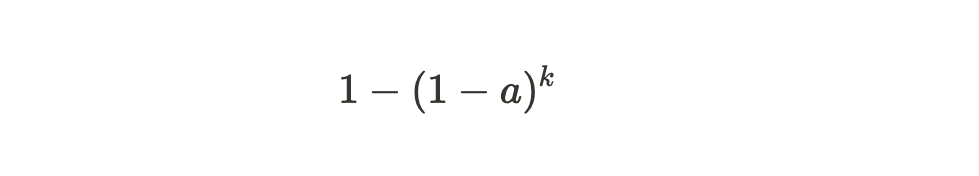

Согласно этой формуле вычислим ошибку первого рода при альфа 5%: 1-(1-0.05)^16 = 0.56 допустимая вероятность ложноположительного результата хотя бы в одном из тестов.


Метод Бонферрони (поправка Бонферрони):

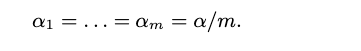

Получается, что 0.05/16 0,003125 - cкорректированный уровень значимости

In [47]:
pivot_size = data.groupby('group')['user_id'].nunique().reset_index()
pivot_size_246 = pivot_size['user_id'][pivot_size['group']==246].sum()
pivot_size_247 = pivot_size['user_id'][pivot_size['group']==247].sum()
pivot_size_248 = pivot_size['user_id'][pivot_size['group']==248].sum()
pivot_size_sum = pivot_size_246 + pivot_size_247

In [48]:
# Переработал таблицу

users_pivot = data.pivot_table(values='user_id', index=['event_name','group'], aggfunc=lambda x: len(x.unique())).reset_index().sort_values(by='user_id', ascending=False)
users_pivot = users_pivot[users_pivot['event_name'] != 'Tutorial'].reset_index().drop('index', axis=1)
users_pivot

,event_name,group,user_id
0,MainScreenAppear,248,2493
1,MainScreenAppear,247,2476
2,MainScreenAppear,246,2450
3,OffersScreenAppear,246,1542
4,OffersScreenAppear,248,1531
5,OffersScreenAppear,247,1520
6,CartScreenAppear,246,1266
7,CartScreenAppear,247,1238
8,CartScreenAppear,248,1230
9,PaymentScreenSuccessful,246,1200


In [49]:
# Изменил функцию
def z_test_new(group1, group2, size1, size2):
    p1 = group1 / size1
    p2 = group2 / size2
    P = (group1 + group2) / (size1 + size2)
    se = sqrt(P*(1-P) * (1/size1 + 1/size2))
    difference = p1 - p2
    z = difference / se
    distr = sp.stats.norm(0, 1)
    p_val = (1 - distr.cdf(abs(z))) * 2
    alpha = .05
    if p_val > alpha:
        print('Оснований отвергать нулевую гипотезу нет, p_val > alpha', p_val)
    else:
        print('Основания отвергать нулевую гипотезу есть, p_val < alpha', p_val)

Для начала выдвинем нулевую и альтенрнативную гипотезы:
- Между группами нет стат.разницы

Альтернативная:
- Между группами есть стат.разницa

## z-test Для MainScreenAppear - 1

Заранее посчитаем переменные для функции

In [50]:
users_pivot_size = users_pivot.pivot_table(values='user_id', index='group', aggfunc='sum').reset_index()
users_pivot_size

,group,user_id
0,246,6458
1,247,6392
2,248,6435


In [51]:
users_pivot_size_246 = users_pivot_size['user_id'][users_pivot_size['group']==246].sum()
users_pivot_size_247 = users_pivot_size['user_id'][users_pivot_size['group']==247].sum()
users_pivot_size_248 = users_pivot_size['user_id'][users_pivot_size['group']==248].sum()

In [52]:
users_pivot_MainScreenAppear = users_pivot[users_pivot['event_name'] == 'MainScreenAppear']
users_pivot_MainScreenAppear_246 = users_pivot_MainScreenAppear['user_id'][users_pivot_MainScreenAppear['group']==246].sum()
users_pivot_MainScreenAppear_247 = users_pivot_MainScreenAppear['user_id'][users_pivot_MainScreenAppear['group']==247].sum()
users_pivot_MainScreenAppear_248 = users_pivot_MainScreenAppear['user_id'][users_pivot_MainScreenAppear['group']==248].sum()

Группы 246 и 247

In [53]:
z_test_new(users_pivot_MainScreenAppear_246, 
           users_pivot_MainScreenAppear_247,
           pivot_size_246,
           pivot_size_247)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.7570597232046099


Группы 246 и 248

In [54]:
z_test_new(users_pivot_MainScreenAppear_246, 
           users_pivot_MainScreenAppear_248,
           pivot_size_246,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.2949721933554552


Группы 247 и 248

In [55]:
z_test_new(users_pivot_MainScreenAppear_247, 
           users_pivot_MainScreenAppear_248,
           pivot_size_247,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.4587053616621515


Группы 246+247 и 248

In [56]:
size_sum = users_pivot_size_247+users_pivot_size_246

In [57]:
group_sum_1 = users_pivot_MainScreenAppear_246+users_pivot_MainScreenAppear_247
z_test_new(group_sum_1, 
           users_pivot_MainScreenAppear_248,
           pivot_size_sum,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.29424526837179577


## z-test Для OffersScreenAppear - 2

In [58]:
users_pivot_OffersScreenAppear = users_pivot[users_pivot['event_name'] == 'OffersScreenAppear']
users_pivot_OffersScreenAppear_246 = users_pivot_OffersScreenAppear['user_id'][users_pivot_OffersScreenAppear['group']==246].sum()
users_pivot_OffersScreenAppear_247 = users_pivot_OffersScreenAppear['user_id'][users_pivot_OffersScreenAppear['group']==247].sum()
users_pivot_OffersScreenAppear_248 = users_pivot_OffersScreenAppear['user_id'][users_pivot_OffersScreenAppear['group']==248].sum()

Группы 246 и 247

In [59]:
z_test_new(users_pivot_OffersScreenAppear_246, 
           users_pivot_OffersScreenAppear_247,
           pivot_size_246,
           pivot_size_247)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.2480954578522181


Группы 246 и 248

In [60]:
z_test_new(users_pivot_OffersScreenAppear_246, 
           users_pivot_OffersScreenAppear_248,
           pivot_size_246,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.20836205402738917


Группы 247 и 248

In [61]:
z_test_new(users_pivot_OffersScreenAppear_247, 
           users_pivot_OffersScreenAppear_248,
           pivot_size_247,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.9197817830592261


Группы 246+247 и 248

In [62]:
group_sum_2 = users_pivot_OffersScreenAppear_247+users_pivot_OffersScreenAppear_246
z_test_new(group_sum_2, 
           users_pivot_OffersScreenAppear_248,
           pivot_size_sum,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.43425549655188256


## z-test Для CartScreenAppear - 3

In [63]:
users_pivot_CartScreenAppear = users_pivot[users_pivot['event_name'] == 'CartScreenAppear']
users_pivot_CartScreenAppear_246 = users_pivot_CartScreenAppear['user_id'][users_pivot_CartScreenAppear['group']==246].sum()
users_pivot_CartScreenAppear_247 = users_pivot_CartScreenAppear['user_id'][users_pivot_CartScreenAppear['group']==247].sum()
users_pivot_CartScreenAppear_248 = users_pivot_CartScreenAppear['user_id'][users_pivot_CartScreenAppear['group']==248].sum()

Группы 246 и 247

In [64]:
z_test_new(users_pivot_CartScreenAppear_246, 
           users_pivot_CartScreenAppear_247,
           pivot_size_246,
           pivot_size_247)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.22883372237997213


Группы 246 и 248

In [65]:
z_test_new(users_pivot_CartScreenAppear_246, 
           users_pivot_CartScreenAppear_248,
           pivot_size_246,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.07842923237520116


Группы 247 и 248

In [66]:
z_test_new(users_pivot_CartScreenAppear_247, 
           users_pivot_CartScreenAppear_248,
           pivot_size_247,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.5786197879539783


Группы 246+247 и 248

In [67]:
group_sum_3 = users_pivot_CartScreenAppear_247+users_pivot_CartScreenAppear_246
z_test_new(group_sum_3, 
           users_pivot_CartScreenAppear_248,
           pivot_size_sum,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.18175875284404386


## z-test Для PaymentScreenSuccessful - 4

In [68]:
users_pivot_PaymentScreenSuccessful = users_pivot[users_pivot['event_name'] == 'PaymentScreenSuccessful']
users_pivot_PaymentScreenSuccessful_246 = users_pivot_PaymentScreenSuccessful['user_id'][users_pivot_PaymentScreenSuccessful['group']==246].sum()
users_pivot_PaymentScreenSuccessful_247 = users_pivot_PaymentScreenSuccessful['user_id'][users_pivot_PaymentScreenSuccessful['group']==247].sum()
users_pivot_PaymentScreenSuccessful_248 = users_pivot_PaymentScreenSuccessful['user_id'][users_pivot_PaymentScreenSuccessful['group']==248].sum()

Группы 246 и 247

In [69]:
z_test_new(users_pivot_PaymentScreenSuccessful_246, 
           users_pivot_PaymentScreenSuccessful_247,
           pivot_size_246,
           pivot_size_247)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.11456679313141849


Группы 246 и 248

In [70]:
z_test_new(users_pivot_PaymentScreenSuccessful_246, 
           users_pivot_PaymentScreenSuccessful_248,
           pivot_size_246,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.2122553275697796


Группы 247 и 248

In [71]:
z_test_new(users_pivot_PaymentScreenSuccessful_247, 
           users_pivot_PaymentScreenSuccessful_248,
           pivot_size_247,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.7373415053803964


Группы 246+247 и 248

In [72]:
group_sum_3 = users_pivot_PaymentScreenSuccessful_247+users_pivot_PaymentScreenSuccessful_246
z_test_new(group_sum_3, 
           users_pivot_PaymentScreenSuccessful_248,
           pivot_size_sum,
           pivot_size_248)

Оснований отвергать нулевую гипотезу нет, p_val > alpha 0.6004294282308704


### Общий вывод:

- Исходя из проведенного теста с группами **246** и **247** можно сказать, что статистических различий между данными нет
- Между группами **246** и **248** по всем событиям статистических различий между данными нет
- Между группами **247** и **248** по всем событиям статистических различий между данными нет
- Статистических различий между группами **246, 247** с экспериментальной **248** нет по всем событиям, соответственно нельзя отвергнуть нулевую гипотезу. Изменение шрифтов в приложении не повлияло на продажи